# PROYECTO ML - COSTO MÉDICO PERSONAL FACTURADO POR EL SEGURO MÉDICO

## OBJETIVO

¿Puedes predecir con precisión los costos del seguro?

## COLUMNAS

columnas

edad: edad del beneficiario principal

sexo: género del contratista de seguros, femenino, masculino

IMC: índice de masa corporal, que proporciona una comprensión del cuerpo, pesos relativamente altos o bajos en relación con la altura,
índice objetivo de peso corporal (kg/m^2) utilizando la relación entre altura y peso, idealmente 18,5 a 24,9.

hijos: Número de hijos cubiertos por el seguro médico / Número de dependientes

fumador: fumar

Región: zona residencial del beneficiario en EE. UU., noreste, sureste, suroeste, noroeste.

cargos: Costos médicos individuales facturados por el seguro médico

## IMPORTACIÓN DE LIBRERÍAS

In [2]:
# Tratamiento de datos
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocesamiento de datos
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from imblearn.over_sampling import SMOTE, RandomOverSampler
from sklearn.utils import resample

# Modelos
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, cross_validate
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error

from sklearn.model_selection import GridSearchCV

## DATA

In [4]:
df = pd.read_csv('../data/raw/insurance.csv')

## PRIMER EXPLORACIÓN DE DATOS

In [5]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [6]:
df.tail()

,age,sex,bmi,children,smoker,region,charges
1333,50,male,30.97,3,no,northwest,10600.5483
1334,18,female,31.92,0,no,northeast,2205.9808
1335,18,female,36.85,0,no,southeast,1629.8335
1336,21,female,25.80,0,no,southwest,2007.9450
1337,61,female,29.07,0,yes,northwest,29141.3603


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [8]:
df.isna().sum()/len(df)*100

age         0.0
sex         0.0
bmi         0.0
children    0.0
smoker      0.0
region      0.0
charges     0.0
dtype: float64

In [9]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [10]:
df.dtypes

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

In [11]:
df.describe(include=object)

,sex,smoker,region
count,1338,1338,1338
unique,2,2,4
top,male,no,southeast
freq,676,1064,364


In [12]:
df[df.duplicated()]

,age,sex,bmi,children,smoker,region,charges
581,19,male,30.59,0,no,northwest,1639.5631


El DataFrame contiene 1338 filas y 7 columnas, sin valores nulos.

COLUMNAS: 
- 'age' = Edad de las personas.<br>
Columna numérica. Tipo: Int64. <br>
La edad va desde los 18 años hasta los 64.

- 'sex' = Género del paciente. <br>
Columna categórica. Tipo: Object.<br>
Se divide en femenino y masculino.

- 'bmi' = Índice de masa corporal. Mide el contenido de grasa corporal en relación a la estatura y el peso que presentan tanto los hombres como las mujeres.<br>
Columna numérica. Tipo: Float64.

- 'children' = Cantidad de hijos.<br>
Columna numérica. Tipo: Int64.

- 'smoker' = Si es fumador o no. <br>
Columna categórica. Tipo: Object.

- 'region' = Región de EEUU donde se encuentra la persona. <br>
Columna categórica. Tipo: Object.

- 'charges' = Son los cargos/costos por cada paciente según las características anteriormente descriptas.<br>
Columna numérica. Tipo: Float64.

## EDA - ANÁLISIS EXPLORATORIO DE DATOS

### CARDINALIDAD

In [13]:
def calcular_cardinalidad(df):
    cardinalidad = pd.DataFrame(index=df.columns)

    cardinalidad['valores_unicos'] = [df[col].nunique() for col in df.columns]
    cardinalidad['porcentaje_cardinalidad'] = round(cardinalidad['valores_unicos'] / len(df) * 100, 2)
    cardinalidad['tipo_de_dato'] = df.dtypes
    cardinalidad['tipo_de_variable'] = ['Categórica' if df[col].dtype == 'object' else 'Numérica' for col in df.columns]

    return cardinalidad

resultado_cardinalidad = calcular_cardinalidad(df)

resultado_cardinalidad

,valores_unicos,porcentaje_cardinalidad,tipo_de_dato,tipo_de_variable
age,47,3.51,int64,Numérica
sex,2,0.15,object,Categórica
bmi,548,40.96,float64,Numérica
children,6,0.45,int64,Numérica
smoker,2,0.15,object,Categórica
region,4,0.30,object,Categórica
charges,1337,99.93,float64,Numérica


### ANÁLISIS UNIVARIANTE

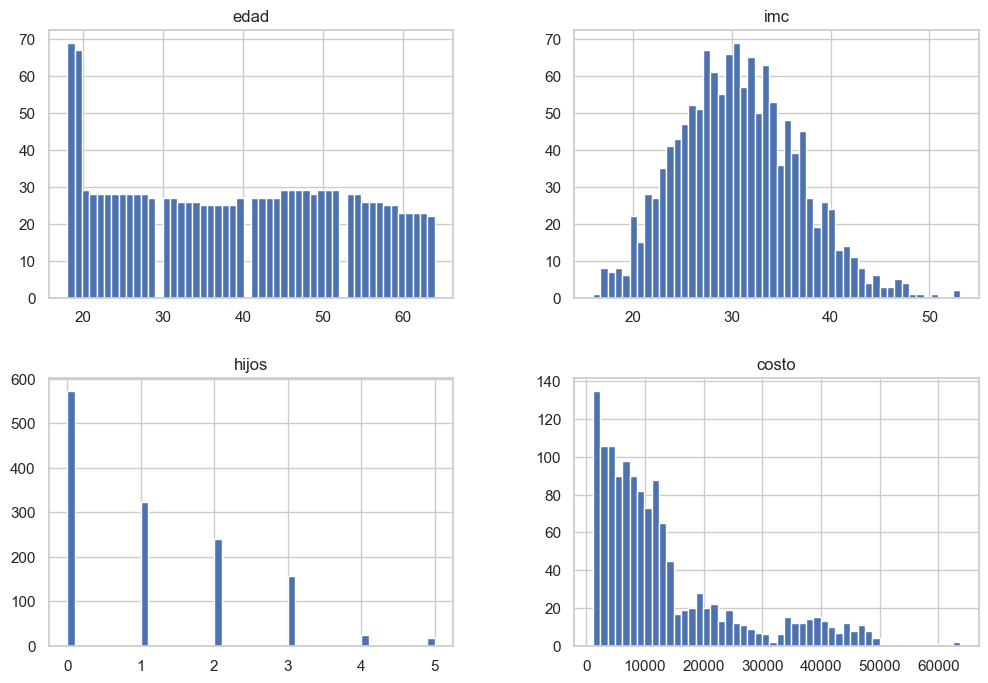

In [55]:
df.hist(bins=50, figsize=(12,8))
plt.show()

In [62]:
df['region'].value_counts()

region
southeast    364
southwest    325
northwest    324
northeast    324
Name: count, dtype: int64

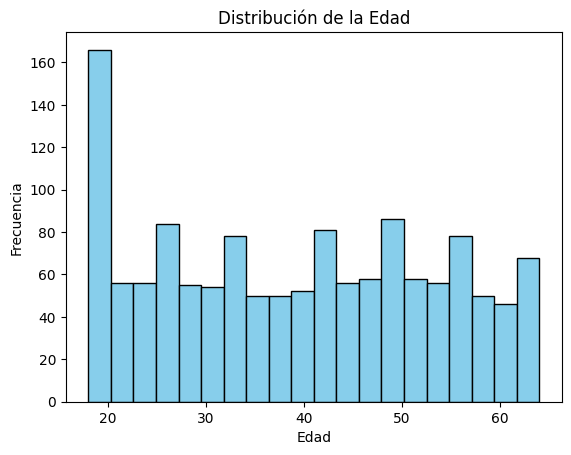

In [14]:

# Crear histograma para la variable 'age'
plt.hist(df['age'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribución de la Edad')
plt.xlabel('Edad')
plt.ylabel('Frecuencia')
plt.show()


{'whiskers': [<matplotlib.lines.Line2D at 0x25a30e154d0>,
 'caps': [<matplotlib.lines.Line2D at 0x25a2d807650>,
 'boxes': [<matplotlib.lines.Line2D at 0x25a30e2ea10>],
 'medians': [<matplotlib.lines.Line2D at 0x25a30e74210>],
 'fliers': [<matplotlib.lines.Line2D at 0x25a30e74a10>],
 'means': []}

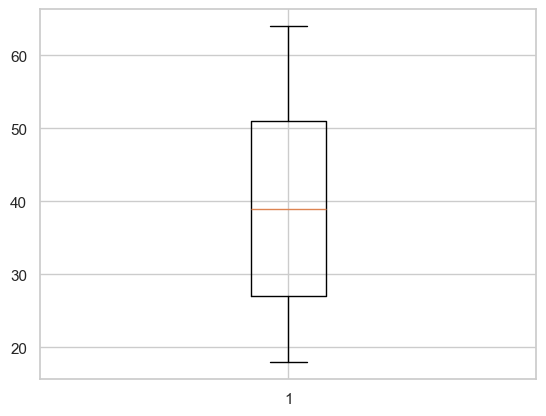

In [54]:
plt.boxplot(df['edad'])

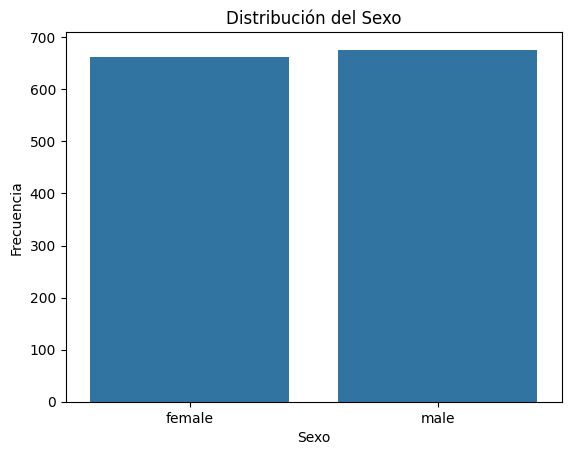

In [15]:
sns.countplot(x='sex', data=df)
plt.title('Distribución del Sexo')
plt.xlabel('Sexo')
plt.ylabel('Frecuencia')
plt.show()

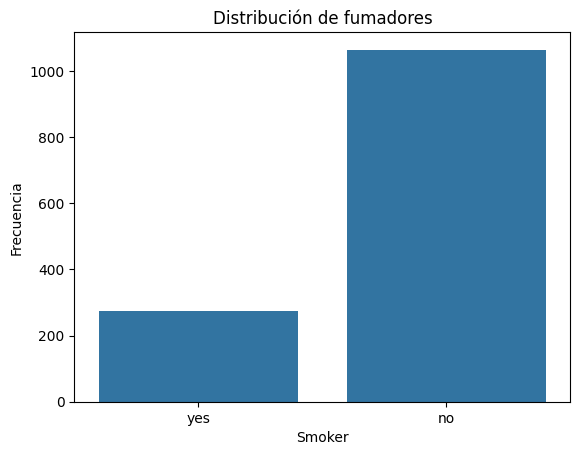

Tabla de frecuencia para 'smoker':
smoker
no     1064
yes     274
Name: count, dtype: int64


In [16]:
sns.countplot(x='smoker', data=df)
plt.title('Distribución de fumadores')
plt.xlabel('Smoker')
plt.ylabel('Frecuencia')
plt.show()
# Tabla de frecuencia para la variable 'smoker'
print("Tabla de frecuencia para 'smoker':")
print(df['smoker'].value_counts())

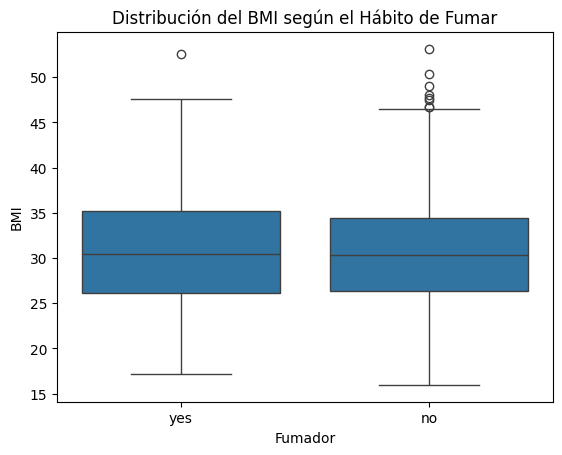

Tabla de contingencia para 'region' y 'smoker':
smoker      no  yes
region             
northeast  257   67
northwest  267   58
southeast  273   91
southwest  267   58


In [17]:
# Boxplot para la variable 'bmi' según la variable 'smoker'
sns.boxplot(x='smoker', y='bmi', data=df)
plt.title('Distribución del BMI según el Hábito de Fumar')
plt.xlabel('Fumador')
plt.ylabel('BMI')
plt.show()

# Tabla de contingencia para las variables 'region' y 'smoker'
contingency_table = pd.crosstab(df['region'], df['smoker'])
print("Tabla de contingencia para 'region' y 'smoker':")
print(contingency_table)

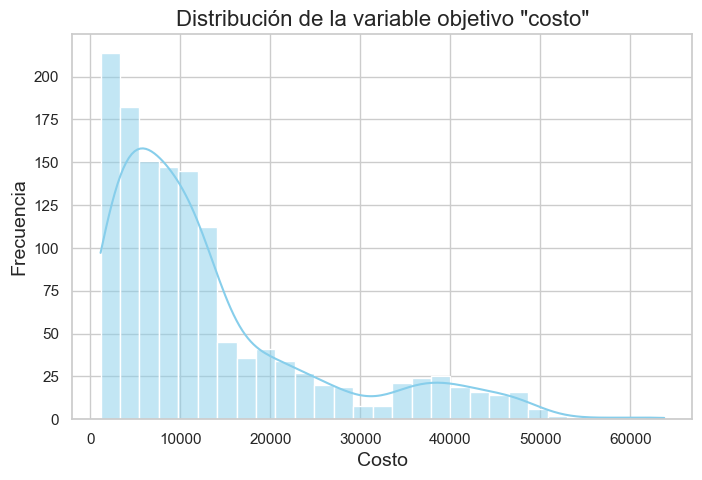

In [41]:
sns.set(style="whitegrid")

# Crear un histograma de la distribución de 'costo'
plt.figure(figsize=(8, 5))
sns.histplot(df['costo'], kde=True, color='skyblue')
plt.title('Distribución de la variable objetivo "costo"', fontsize=16)
plt.xlabel('Costo', fontsize=14)
plt.ylabel('Frecuencia', fontsize=14)
plt.show()

Puede observarse una distribución asimétrica positiva de la target

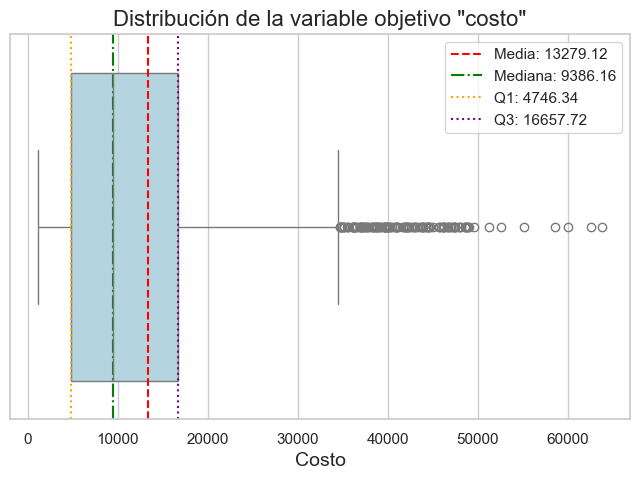

In [43]:
plt.figure(figsize=(8, 5))
sns.boxplot(x='costo', data=df, color='lightblue')
plt.title('Distribución de la variable objetivo "costo"', fontsize=16)
plt.xlabel('Costo', fontsize=14)

# Calcular la media y la mediana
media = df['costo'].mean()
mediana = df['costo'].median()

# Añadir líneas para la media y la mediana
plt.axvline(media, color='red', linestyle='--', label=f'Media: {media:.2f}')
plt.axvline(mediana, color='green', linestyle='-.', label=f'Mediana: {mediana:.2f}')

# Añadir líneas para los rangos intercuartílicos
cuartil_25 = df['costo'].quantile(0.25)
cuartil_75 = df['costo'].quantile(0.75)
plt.axvline(cuartil_25, color='orange', linestyle=':', label=f'Q1: {cuartil_25:.2f}')
plt.axvline(cuartil_75, color='purple', linestyle=':', label=f'Q3: {cuartil_75:.2f}')

plt.legend()
plt.show()

Y acá vemos porque la distribución no es normal, existen muchos outliers en la variable objetivo.

In [45]:
df[['costo']].describe()

,costo
count,1337.000000
mean,13279.121487
std,12110.359656
min,1121.873900
25%,4746.344000
50%,9386.161300
75%,16657.717450
max,63770.428010


### ANÁLISIS BIVARIANTE

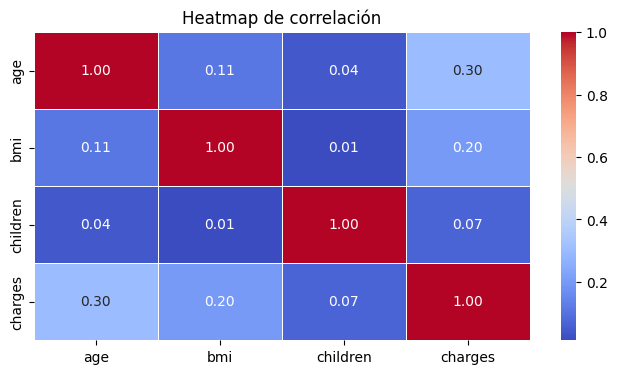

In [18]:
# Filtrar solo las columnas numéricas
df_numeric = df.select_dtypes(include=['int64', 'float64'])

# Calcular la matriz de correlación
corr_matrix = df_numeric.corr()

# Crear el heatmap
plt.figure(figsize=(8, 4))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Heatmap de correlación")
plt.show()


## LIMPIEZA

#### Duplicados

In [19]:
df[df.duplicated()]

,age,sex,bmi,children,smoker,region,charges
581,19,male,30.59,0,no,northwest,1639.5631


Al observar que existe un dupliado en la fila 581, lo eliminamos: 

In [20]:
df = df.drop_duplicates()

#### Traducciones etiquetas columnas

Los nombres de las columnas se encuentran en inglés, por lo que realizaré la traducción al español de las etiquetas. 

In [21]:
nombres_columnas = ['edad', 'sexo', 'imc', 'hijos', 'fumador', 'region', 'costo']
df.columns = nombres_columnas

In [22]:
df

,edad,sexo,imc,hijos,fumador,region,costo
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


In [24]:
df.to_csv('../data/processed/df_limpio.csv')

## DIVISIÓN DE LOS DATOS 

Descargo el DataFrame luego de la limpieza en la variable 'df'

In [62]:
df = pd.read_csv('../data/processed/df_limpio.csv', index_col=[0])

En primer lugar, hay que realizar la división de los datos entre las características, es decir, las variables independientes que sería **'X'**, y la target, que sería la variable dependiente, o sea, **'y'**. 

**'y'** es la variable objetivo, aquello que queremos predecir con los modelos de Regresión Lineal, ya que es una variable numérica continua. 

## FEATURE ENGINEERING

#### 'smoker' = Mapeo 

In [63]:
mapeo_fumador = {'yes': 1, 'no': 0}

df['fumador'] = df['fumador'].map(mapeo_fumador)


In [64]:
df['fumador'].value_counts()

fumador
0    1063
1     274
Name: count, dtype: int64

#### 'sexo' = Mapeo

In [72]:
df['es_femenino'] = df['sexo'].map({'female': 1, 'male': 0})

df.drop('sexo', axis=1, inplace=True)

#### Columna 'region' = LabelEncoder

In [69]:
label_encoder = LabelEncoder()
df['regiones'] = label_encoder.fit_transform(df['region'])

df.drop('region', axis=1, inplace=True)

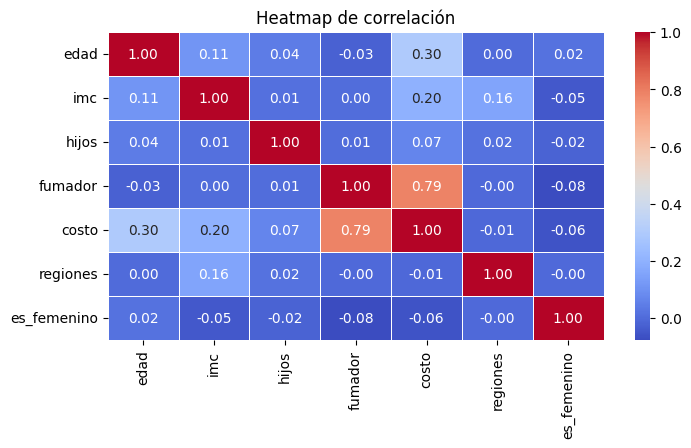

In [73]:
corr_matrix = df.corr()

plt.figure(figsize=(8, 4))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Heatmap de correlación")
plt.show()

In [74]:
correlation_matrix = df.corr(method='pearson')

correlation_with_target = correlation_matrix['costo']['regiones']

if abs(correlation_with_target) < 0.1:
    print("La columna 'regiones' podría ser eliminada debido a su baja correlación con la variable objetivo.")
else:
    print("La columna 'regiones' tiene una correlación significativa con la variable objetivo y no debería ser eliminada.")


La columna 'regiones' podría ser eliminada debido a su baja correlación con la variable objetivo.


VIENDO QUE 'COSTO' CON LA VARIABLE 'REGIONES' SON LAS VARIABLES QUE MENOS CORRELACION TIENEN, PROCEDO A ELIMINAR DICHA COLUMNA PARA UN MEJOR RESULTADO DEL MODELO. 

In [75]:
df = df.drop(['regiones'], axis=1)

#### GUARDO DF CON TODAS LAS TRANSFORMACIONES NUMÉRICAS, PREPARADO PARA EL FEATURE ENGINEERING.

In [38]:
df.to_csv('../data/processed/df_numerico_para_F_E.csv')

## DIVISIÓN DE DATOS

In [53]:
df = pd.read_csv('../data/processed/df_numerico_para_F_E.csv', index_col=[0])

In [54]:
df

,edad,imc,hijos,fumador,costo,es_femenino
0,19,27.900,0,1,16884.92400,1
1,18,33.770,1,0,1725.55230,0
2,28,33.000,3,0,4449.46200,0
3,33,22.705,0,0,21984.47061,0
4,32,28.880,0,0,3866.85520,0
...,...,...,...,...,...,...
1333,50,30.970,3,0,10600.54830,0
1334,18,31.920,0,0,2205.98080,1
1335,18,36.850,0,0,1629.83350,1
1336,21,25.800,0,0,2007.94500,1


In [55]:
X = df.drop(columns='costo') 
y = df['costo']               

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [57]:
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)

X_train: (1069, 5)
y_train: (1069,)
X_test: (268, 5)
y_test: (268,)


> Prueba entreanmiento sin las transformaciones

In [58]:
modelo_lr = LinearRegression()

modelo_lr.fit(X_train, y_train)

predicciones = modelo_lr.predict(X_test)

In [59]:
# Rendimiento del modelo
mse = mean_squared_error(y_test, predicciones)
print("Error cuadrático medio en el conjunto de prueba:", mse)

rmse = mean_squared_error(y_test, predicciones, squared=False)
print("Raíz del Error Cuadrático Medio en el conjunto de prueba:", rmse)

score = modelo_lr.score(X_test, y_test)
print("Puntaje R^2 en el conjunto de prueba:", score)

mae = mean_absolute_error(y_test, predicciones)

# MAPE
mape = mae * 100

print("Error Porcentual Absoluto Medio (MAPE) en el conjunto de prueba:", mape)


Error cuadrático medio en el conjunto de prueba: 35901914.114619836
Raíz del Error Cuadrático Medio en el conjunto de prueba: 5991.820601004326
Puntaje R^2 en el conjunto de prueba: 0.804621881177266
Error Porcentual Absoluto Medio (MAPE) en el conjunto de prueba: 419811.18004745996


## FEATURE ENGINEERING

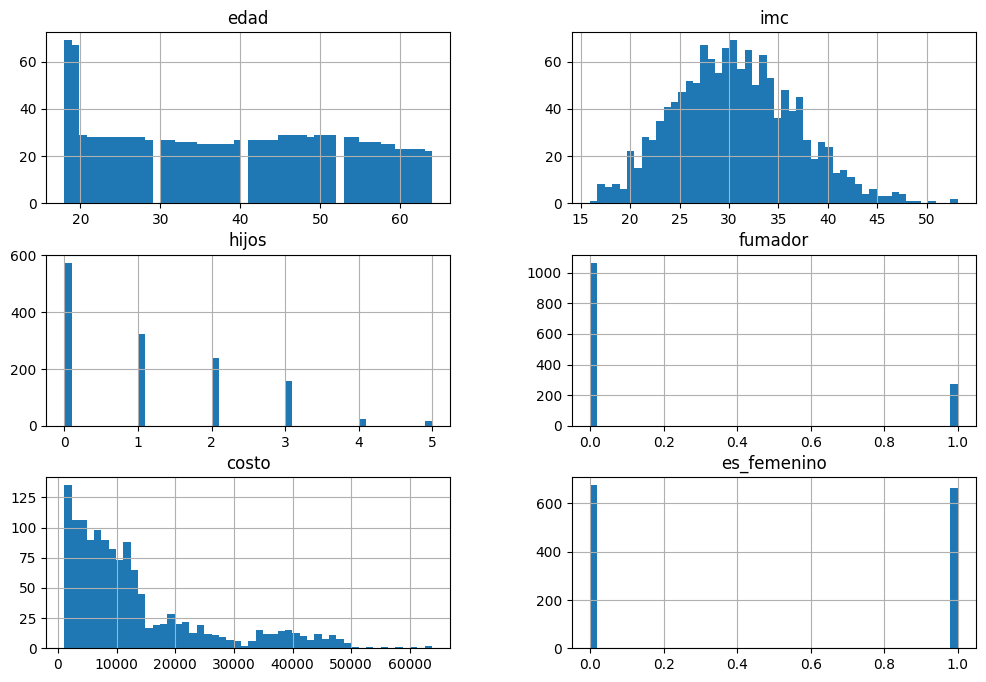

In [39]:
df.hist(bins=50, figsize=(12,8))
plt.show()

#### LOGARITMO A 'costo' y 'edad'

In [60]:
# Logaritmo de la target 'costo'
y_train = np.log(y_train)
y_test = np.log(y_test) 

# Logaritmo de 'edad'
X_train['edad'] = np.log(X_train['edad']) 
X_test['edad'] = np.log(X_test['edad'])

#### ESCALADO A 'costo', 'edad', 'imc', 'hijos'

In [61]:
# Creamos un objeto StandardScaler para 'X'
scaler_X = StandardScaler()

# Definimos las columnas a escalar
columns_to_scale = ['edad', 'hijos', 'imc']

# Ajustamos y transformamos X_train
X_train[columns_to_scale] = scaler_X.fit_transform(X_train[columns_to_scale])

# Aplicamos la misma transformación a X_test
X_test[columns_to_scale] = scaler_X.transform(X_test[columns_to_scale])

In [62]:
# Creamos un objeto StandardScaler para 'y'
scaler_y = StandardScaler()

# Ajustamos y transformamos y_train
y_train = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()

# Aplicamos la misma transformación a y_test
y_test = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()

## BASE LINE Y CROSS VALIDATION

In [63]:

# Definir los modelos
modelos = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(),
    "SVR": SVR(),
    "DecisionTreeRegressor": DecisionTreeRegressor(),
    "RandomForestRegressor": RandomForestRegressor(),
    "KNeighborsRegressor": KNeighborsRegressor(),
    "GradientBoostingRegressor": GradientBoostingRegressor(),
    "XGBRegressor": XGBRegressor(),
    "LGBMRegressor": LGBMRegressor(),
    "CatBoostRegressor": CatBoostRegressor(silent=True)  # Desactiva la salida de impresión
}

resultados = {}

for nombre, modelo in modelos.items():
    scoring = {'R2': 'r2', 'MAE': 'neg_mean_absolute_error'}
    scores = cross_validate(modelo, X_train, y_train, cv=3, scoring=scoring)
    resultados[nombre] = {
        'R2': np.mean(scores['test_R2']),
        'MAE': np.mean(-scores['test_MAE'])
    }


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000151 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 293
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 5
[LightGBM] [Info] Start training from score 0.016136
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

In [64]:
# Imprimir DataFrame
df_resultados = pd.DataFrame(resultados).T 
df_resultados.sort_values(by='R2', ascending=False)

,R2,MAE
GradientBoostingRegressor,0.803547,0.237608
SVR,0.803212,0.205519
LGBMRegressor,0.788792,0.255475
CatBoostRegressor,0.787071,0.246018
RandomForestRegressor,0.778257,0.249812
LinearRegression,0.744194,0.329228
Ridge,0.744162,0.329840
KNeighborsRegressor,0.735820,0.303825
XGBRegressor,0.728810,0.283581
DecisionTreeRegressor,0.600220,0.305345


### SVR()

In [31]:
modelo = SVR()

# Define los hiperparámetros que quieres ajustar
parametros = {
    'kernel': ['linear', 'rbf', 'poly'],
    'C': [0.1, 1, 10],
    'epsilon': [0.1, 0.01, 0.001],
    'gamma': ['scale', 'auto']
}

# Realiza la búsqueda de cuadrícula con validación cruzada
grid_search = GridSearchCV(modelo, parametros, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)

# Ajusta la búsqueda de cuadrícula a tus datos
grid_search.fit(X_train, y_train)

# Muestra los mejores hiperparámetros encontrados
print("Mejores hiperparámetros encontrados:")
print(grid_search.best_params_)

# Muestra el mejor puntaje de validación cruzada
print("Mejor puntuación de validación cruzada:", grid_search.best_score_)

# Obtén el mejor modelo
mejor_modelo = grid_search.best_estimator_

Mejores hiperparámetros encontrados:
{'C': 10, 'epsilon': 0.1, 'gamma': 'auto', 'kernel': 'rbf'}
Mejor puntuación de validación cruzada: -0.19396874796241245


#### MEJOR MODELO E HIPERPARÁMETROS

In [50]:
mejor_modelo

SVR(C=10, gamma='auto')

In [65]:
mejor_modelo_svr = SVR(C=10, epsilon=0.1, gamma='auto', kernel='rbf')

## PREDICCIONES

In [66]:
# Define el modelo SVR con los mejores hiperparámetros encontrados
mejor_modelo_svr = SVR(C=10, epsilon=0.1, gamma='auto', kernel='rbf')

# Ajusta el modelo a tus datos de entrenamiento
mejor_modelo_svr.fit(X_train, y_train)

# Haz predicciones en tus datos de prueba
predicciones = mejor_modelo_svr.predict(X_test)

# Calcular MSE
mse = mean_squared_error(y_test, predicciones)

# Calcular MAE
mae = mean_absolute_error(y_test, predicciones)

# Calcular R2
r2 = r2_score(y_test, predicciones)

# Calcular RMSE (Root Mean Squared Error)
rmse = np.sqrt(mse)

print("Error cuadrático medio (MSE):", mse)
print("Error absoluto medio (MAE):", mae)
print("Coeficiente de determinación (R^2):", r2)
print("Raíz del error cuadrático medio (RMSE):", rmse)

Error cuadrático medio (MSE): 0.13955269582864313
Error absoluto medio (MAE): 0.1790112666740389
Coeficiente de determinación (R^2): 0.8764460374877766
Raíz del error cuadrático medio (RMSE): 0.37356752512583735


In [67]:
r2_score(y_test, mejor_modelo_svr.predict(X_test))

0.8764460374877766

In [68]:
predicciones = scaler_y.inverse_transform(predicciones.reshape(-1, 1))

# Invertir la transformación logarítmica
predicciones = np.exp(predicciones)

# Ver las predicciones en su escala original
print(predicciones)

[[ 8823.35905672]
 [ 6852.60381253]
 [12448.37128009]
 [41711.42678958]
 [ 4855.60004011]
 [10189.88310601]
 [43377.61746654]
 [ 2381.19524476]
 [ 8031.76764769]
 [10326.99023009]
 [14093.7493457 ]
 [28385.54986156]
 [35025.17438562]
 [14090.71319953]
 [ 6309.09646915]
 [ 8872.21592987]
 [ 2110.72554828]
 [39888.47187087]
 [ 4184.7064499 ]
 [ 4311.06562888]
 [ 2088.36407142]
 [20878.48356387]
 [10467.05649993]
 [22557.72651423]
 [43122.82884011]
 [ 3623.5339021 ]
 [46416.85648536]
 [45359.96329029]
 [10018.01843891]
 [12965.9750177 ]
 [ 4104.73036935]
 [ 9864.17840231]
 [ 1938.04834385]
 [13551.873395  ]
 [29896.73757653]
 [10797.33410967]
 [ 8223.04375174]
 [ 5694.62206976]
 [22410.21164004]
 [ 8966.08453362]
 [ 2291.63681147]
 [18653.38802946]
 [48783.98114656]
 [10208.31114562]
 [ 9367.37436586]
 [ 3467.14503477]
 [ 1789.59899977]
 [ 7942.31208517]
 [ 4142.92399406]
 [ 6928.20748541]
 [ 4706.96900087]
 [ 5663.11070422]
 [20083.00964026]
 [ 1555.23494529]
 [ 7821.02788422]
 [ 8460.32

In [69]:
# Calcular R^2 en datos de entrenamiento
r2_train = r2_score(y_train, mejor_modelo.predict(X_train))
print('R^2 en datos de entrenamiento:', r2_train)

# Calcular R^2 en datos de prueba
r2_test = r2_score(y_test, predicciones)
print('R^2 en datos de prueba:', r2_test)


R^2 en datos de entrenamiento: 0.8204164648824043
R^2 en datos de prueba: -299151531.32035


## Gradient Boost

In [79]:
# Definir el modelo
modelo = GradientBoostingRegressor()

# Definir los parámetros que quieres ajustar
parametros = {
    'learning_rate': [0.01, 0.1, 0.5],
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7]
}

# Realizar la búsqueda de cuadrícula con validación cruzada
grid_search = GridSearchCV(modelo, parametros, cv=3, scoring='r2', n_jobs=-1)

# Ajustar la búsqueda de cuadrícula a tus datos de entrenamiento
grid_search.fit(X_train, y_train)

# Mostrar los mejores hiperparámetros encontrados
print("Mejores hiperparámetros encontrados:")
print(grid_search.best_params_)

# Mostrar el mejor puntaje de validación cruzada
print("Mejor puntuación de validación cruzada:", grid_search.best_score_)

# Obtener el mejor modelo
mejor_modelo_gb = grid_search.best_estimator_

# Hacer predicciones en datos de entrenamiento y prueba
predicciones_train = mejor_modelo_gb.predict(X_train)
predicciones_test = mejor_modelo_gb.predict(X_test)

# Calcular R^2 en datos de entrenamiento y prueba
r2_train = r2_score(y_train, predicciones_train)
r2_test = r2_score(y_test, predicciones_test)

print('R^2 en datos de entrenamiento:', r2_train)
print('R^2 en datos de prueba:', r2_test)


Mejores hiperparámetros encontrados:
{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}
Mejor puntuación de validación cruzada: 0.8157598269414437
R^2 en datos de entrenamiento: 0.8471826180955636
R^2 en datos de prueba: 0.8815142546080172


In [80]:
# Definir el modelo
modelo = GradientBoostingRegressor()

# Entrenar el modelo
modelo.fit(X_train, y_train)

# Hacer predicciones en datos de entrenamiento y prueba
predicciones_train = modelo.predict(X_train)
predicciones_test = modelo.predict(X_test)

# Calcular R^2 en datos de entrenamiento y prueba
r2_train = r2_score(y_train, predicciones_train)
r2_test = r2_score(y_test, predicciones_test)

print('R^2 en datos de entrenamiento:', r2_train)
print('R^2 en datos de prueba:', r2_test)


R^2 en datos de entrenamiento: 0.8717475521924973
R^2 en datos de prueba: 0.8774388706919336


In [73]:
def revertir_transformaciones_y_test(y_test, scaler_y):
    # Aplicar la transformación inversa del escalado estándar a y_test
    y_test_inverso = scaler_y.inverse_transform(y_test.reshape(-1, 1))
    
    # Deshacer la transformación logarítmica
    y_test_inverso = np.exp(y_test_inverso)
    
    return y_test_inverso

In [74]:
y_test_inverso = revertir_transformaciones_y_test(y_test, scaler_y)

## LGBMRegressor()

In [76]:
# Definir el modelo
modelo = LGBMRegressor()

# Definir los parámetros que quieres ajustar
parametros = {
    'learning_rate': [0.01, 0.1, 0.5],
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7]
}

# Realizar la búsqueda de cuadrícula con validación cruzada
grid_search = GridSearchCV(modelo, parametros, cv=3, scoring='r2', n_jobs=-1)

# Ajustar la búsqueda de cuadrícula a tus datos de entrenamiento
grid_search.fit(X_train, y_train)

# Mostrar los mejores hiperparámetros encontrados
print("Mejores hiperparámetros encontrados:")
print(grid_search.best_params_)

# Mostrar el mejor puntaje de validación cruzada
print("Mejor puntuación de validación cruzada:", grid_search.best_score_)

# Obtener el mejor modelo
mejor_modelo_lgbm = grid_search.best_estimator_

# Hacer predicciones en datos de entrenamiento y prueba
predicciones_train = mejor_modelo_lgbm.predict(X_train)
predicciones_test = mejor_modelo_lgbm.predict(X_test)

# Calcular R^2 en datos de entrenamiento y prueba
r2_train = r2_score(y_train, predicciones_train)
r2_test = r2_score(y_test, predicciones_test)

print('R^2 en datos de entrenamiento:', r2_train)
print('R^2 en datos de prueba:', r2_test)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000173 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 314
[LightGBM] [Info] Number of data points in the train set: 1069, number of used features: 5
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

In [81]:
# Definir el modelo
modelo = CatBoostRegressor(verbose=False)

# Definir los parámetros que quieres ajustar
parametros = {
    'learning_rate': [0.01, 0.1, 0.5],
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7]
}

# Realizar la búsqueda de cuadrícula con validación cruzada
grid_search = GridSearchCV(modelo, parametros, cv=3, scoring='r2', n_jobs=-1)

# Ajustar la búsqueda de cuadrícula a tus datos de entrenamiento
grid_search.fit(X_train, y_train)

# Mostrar los mejores hiperparámetros encontrados
print("Mejores hiperparámetros encontrados:")
print(grid_search.best_params_)

# Mostrar el mejor puntaje de validación cruzada
print("Mejor puntuación de validación cruzada:", grid_search.best_score_)

# Obtener el mejor modelo
mejor_modelo_catboost = grid_search.best_estimator_

# Hacer predicciones en datos de entrenamiento y prueba
predicciones_train = mejor_modelo_catboost.predict(X_train)
predicciones_test = mejor_modelo_catboost.predict(X_test)

# Calcular R^2 en datos de entrenamiento y prueba
r2_train = r2_score(y_train, predicciones_train)
r2_test = r2_score(y_test, predicciones_test)

print('R^2 en datos de entrenamiento:', r2_train)
print('R^2 en datos de prueba:', r2_test)


Mejores hiperparámetros encontrados:
{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50}
Mejor puntuación de validación cruzada: 0.8168209423408697
R^2 en datos de entrenamiento: 0.8396955733015995
R^2 en datos de prueba: 0.8782040299406224


## Random Forest

In [78]:
# Definir el modelo
modelo = RandomForestRegressor()

# Definir los parámetros que quieres ajustar
parametros = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 3, 5, 7]
}

# Realizar la búsqueda de cuadrícula con validación cruzada
grid_search = GridSearchCV(modelo, parametros, cv=3, scoring='r2', n_jobs=-1)

# Ajustar la búsqueda de cuadrícula a tus datos de entrenamiento
grid_search.fit(X_train, y_train)

# Mostrar los mejores hiperparámetros encontrados
print("Mejores hiperparámetros encontrados:")
print(grid_search.best_params_)

# Mostrar el mejor puntaje de validación cruzada
print("Mejor puntuación de validación cruzada:", grid_search.best_score_)

# Obtener el mejor modelo
mejor_modelo_rf = grid_search.best_estimator_

# Hacer predicciones en datos de entrenamiento y prueba
predicciones_train = mejor_modelo_rf.predict(X_train)
predicciones_test = mejor_modelo_rf.predict(X_test)

# Calcular R^2 en datos de entrenamiento y prueba
r2_train = r2_score(y_train, predicciones_train)
r2_test = r2_score(y_test, predicciones_test)

print('R^2 en datos de entrenamiento:', r2_train)
print('R^2 en datos de prueba:', r2_test)


Mejores hiperparámetros encontrados:
{'max_depth': 5, 'n_estimators': 100}
Mejor puntuación de validación cruzada: 0.8069653715105867
R^2 en datos de entrenamiento: 0.8448208808664572
R^2 en datos de prueba: 0.8770750743702906


## gridsearch modelos

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

# Define los modelos que quieres evaluar
modelos = {
    'SVR': SVR(),
    'GradientBoostingRegressor': GradientBoostingRegressor(),
    'LGBMRegressor': LGBMRegressor(),
    'CatBoostRegressor': CatBoostRegressor(),
    'RandomForestRegressor': RandomForestRegressor()
}

# Define los hiperparámetros que quieres ajustar para SVR
parametros_svr = {
    'kernel': ['linear', 'rbf', 'poly'],
    'C': [0.1, 1, 10],
    'epsilon': [0.1, 0.01, 0.001],
    'gamma': ['scale', 'auto']
}

# Define los hiperparámetros que quieres ajustar para GradientBoostingRegressor
parametros_gradient = {
    'learning_rate': [0.01, 0.1, 0.5],
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7]
}

# Define los hiperparámetros que quieres ajustar para LGBMRegressor
parametros_lgbm = {
    'learning_rate': [0.01, 0.1, 0.5],
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7]
}

# Define los hiperparámetros que quieres ajustar para CatBoostRegressor
parametros_catboost = {
    'learning_rate': [0.01, 0.1, 0.5],
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7]
}

# Define los hiperparámetros que quieres ajustar para RandomForestRegressor
parametros_randomforest = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7]
}

# Realiza la búsqueda de cuadrícula para cada modelo
mejores_modelos = {}
for nombre_modelo, modelo in modelos.items():
    print("Grid search para", nombre_modelo)
    if nombre_modelo == 'SVR':
        grid_search = GridSearchCV(modelo, parametros_svr, cv=3, scoring='r2', n_jobs=-1)
    elif nombre_modelo == 'GradientBoostingRegressor':
        grid_search = GridSearchCV(modelo, parametros_gradient, cv=3, scoring='r2', n_jobs=-1)
    elif nombre_modelo == 'LGBMRegressor':
        grid_search = GridSearchCV(modelo, parametros_lgbm, cv=3, scoring='r2', n_jobs=-1)
    elif nombre_modelo == 'CatBoostRegressor':
        grid_search = GridSearchCV(modelo, parametros_catboost, cv=3, scoring='r2', n_jobs=-1)
    elif nombre_modelo == 'RandomForestRegressor':
        grid_search = GridSearchCV(modelo, parametros_randomforest, cv=3, scoring='r2', n_jobs=-1)
    
    grid_search.fit(X_train, y_train)
    mejores_modelos[nombre_modelo] = grid_search.best_estimator_
    print("Mejores hiperparámetros encontrados:", grid_search.best_params_)
    print("Mejor R2:", grid_search.best_score_)
    print()

# Utiliza el mejor modelo según R2
mejor_modelo_nombre = max(mejores_modelos, key=lambda k: grid_search.best_score_)
mejor_modelo = mejores_modelos[mejor_modelo_nombre]
print("Mejor modelo según R2:", mejor_modelo_nombre)
